In [4]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import re, random
import spacy
from urllib.request import urlopen


In [5]:
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00


In [6]:
from wordfreq import zipf_frequency

In [ ]:
nlp = spacy.load("en_core_web_sm")


In [ ]:
urls = {
    "Wilde": "https://www.gutenberg.org/files/174/174-0.txt",      # The Picture of Dorian Gray
    "Austen": "https://www.gutenberg.org/files/1342/1342-0.txt",   # Pride and Prejudice
    "Eliot": "https://www.gutenberg.org/files/145/145-0.txt"       # Middlemarch
}

texts = {}
for author, url in urls.items():
    raw = urlopen(url).read().decode("utf-8", errors="ignore")
    texts[author] = raw

In [ ]:
def get_words(text):
    tokens = re.findall(r"[A-Za-z]+", text.lower())
    tokens = [t for t in tokens if len(t) > 3]
    return list(set(tokens))


In [ ]:
words = []
for author, txt in texts.items():
    ws = get_words(txt)
    words.extend([(w, author) for w in ws])

df_words = pd.DataFrame(words, columns=["word", "author"])


In [ ]:
df_lit = pd.DataFrame(words, columns=["word", "author"])
df_lit = df_lit.sample(200, random_state=42).reset_index(drop=True)
df_lit["source"] = "literary"

In [ ]:
df_brys = pd.read_csv("/content/Concreteness_ratings_Brysbaert_et_al_BRM.csv")
df_brys['Word'] = df_brys['Word'].astype(str).str.lower()

# Taking first 200 words
df_brys200 = df_brys.head(200).copy()
df_brys200["author"] = "Brysbaert"
df_brys200["source"] = "neutral"

In [ ]:
merged_lit = pd.merge(df_lit, df_brys, left_on="word", right_on="Word", how="left")

In [ ]:
merged_lit["zipf_freq"] = merged_lit["word"].apply(lambda w: zipf_frequency(w, "en"))
z = merged_lit["zipf_freq"].replace(-float("inf"), np.nan)

merged_lit["conc_m"] = merged_lit["Conc.M"].combine_first(((z - z.min()) / (z.max() - z.min()) * 4) + 1)
merged_lit["conc_sd"] = merged_lit["Conc.SD"].fillna(merged_lit["conc_m"] * 0.2)
merged_lit["percent_known"] = merged_lit["Percent_known"].combine_first(((z - z.min()) / (z.max() - z.min())) * 100)


In [ ]:
#pos tags for literary words
def get_pos(word):
    doc = nlp(word)
    return doc[0].pos_ if len(doc) > 0 else "X"

merged_lit["dom_pos"] = merged_lit["word"].apply(get_pos)

In [ ]:
merged_lit["word_len"] = merged_lit["word"].apply(len)
merged_lit["len_times_conc"] = merged_lit["word_len"] * merged_lit["conc_m"]


In [ ]:
cols = ["word", "author", "conc_m", "Conc.SD", "Percent_known", "word_len", "source"]


In [ ]:
final_lit = merged_lit[[
    "word", "author", "conc_m", "conc_sd", "percent_known",
    "dom_pos", "word_len", "len_times_conc", "zipf_freq", "source"
]]


In [ ]:
final_brys = df_brys200.rename(columns={
    "Conc.M": "conc_m",
    "Conc.SD": "conc_sd",
    "Percent_known": "percent_known"
})
final_brys["word_len"] = final_brys["Word"].apply(len)
final_brys["len_times_conc"] = final_brys["word_len"] * final_brys["conc_m"]
final_brys["zipf_freq"] = final_brys["Word"].apply(lambda w: zipf_frequency(w, "en"))
final_brys["dom_pos"] = final_brys["Word"].apply(get_pos)

final_brys = final_brys[[
    "Word", "author", "conc_m", "conc_sd", "percent_known",
    "dom_pos", "word_len", "len_times_conc", "zipf_freq", "source"
]].rename(columns={"Word": "word"})

In [ ]:
final_combined = pd.concat([final_lit, final_brys], ignore_index=True)
final_combined.dropna(subset=["conc_m"], inplace=True)


In [ ]:
final_combined.to_csv("literary_brysbaert_combined.csv", index=False)

print(f"✅ Combined dataset created successfully! Shape: {final_combined.shape}")
print(final_combined.head(400))

✅ Combined dataset created successfully! Shape: (400, 10)
          word     author    conc_m   conc_sd  percent_known dom_pos  \
0    burnished      Wilde  2.494891  0.498978      37.372263    VERB   
1     chillest      Eliot  2.121168  0.424234      28.029197   PROPN   
2        bushy      Wilde  3.750000  1.270000       0.970000     ADJ   
3     involves      Eliot  3.534307  0.706861      63.357664    VERB   
4      collect      Wilde  3.340000  1.320000       1.000000    VERB   
..         ...        ...       ...       ...            ...     ...   
395       waxy  Brysbaert  4.100000  0.990000       1.000000    VERB   
396   bicuspid  Brysbaert  4.090000  1.310000       0.880000    NOUN   
397   fluorine  Brysbaert  4.090000  1.470000       0.850000    NOUN   
398     bloody  Brysbaert  4.080000  1.250000       1.000000     ADJ   
399     starry  Brysbaert  4.080000  1.150000       0.930000     ADJ   

     word_len  len_times_conc  zipf_freq    source  
0           9       22.4

In [7]:
df = pd.read_csv("/content/literary_brysbaert_combined.csv")


In [ ]:
print("Dataset shape:", df.shape)
print("\nColumns and types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

Dataset shape: (400, 10)

Columns and types:
 word               object
author             object
conc_m            float64
conc_sd           float64
percent_known     float64
dom_pos            object
word_len            int64
len_times_conc    float64
zipf_freq         float64
source             object
dtype: object

Missing values per column:
 word              0
author            0
conc_m            0
conc_sd           0
percent_known     0
dom_pos           0
word_len          0
len_times_conc    0
zipf_freq         0
source            0
dtype: int64


In [ ]:
numeric_cols = ["conc_m", "conc_sd", "percent_known", "word_len", "len_times_conc", "zipf_freq"]
print("\nNumeric summary:\n", df[numeric_cols].describe())



Numeric summary:
            conc_m     conc_sd  percent_known    word_len  len_times_conc  \
count  400.000000  400.000000     400.000000  400.000000      400.000000   
mean     3.496375    0.939370       8.409359    7.497500       25.589583   
std      1.087361    0.333604      18.089315    2.352409       10.295786   
min      1.000000    0.000000       0.000000    3.000000        4.000000   
25%      2.493431    0.691259       1.000000    6.000000       17.590000   
50%      4.110000    0.990000       1.000000    7.000000       24.490000   
75%      4.330000    1.170000       1.000000    9.000000       32.760000   
max      5.000000    1.590000      76.642336   14.000000       56.160000   

        zipf_freq  
count  400.000000  
mean     3.174325  
std      1.286111  
min      0.000000  
25%      2.410000  
50%      3.230000  
75%      4.062500  
max      6.850000  


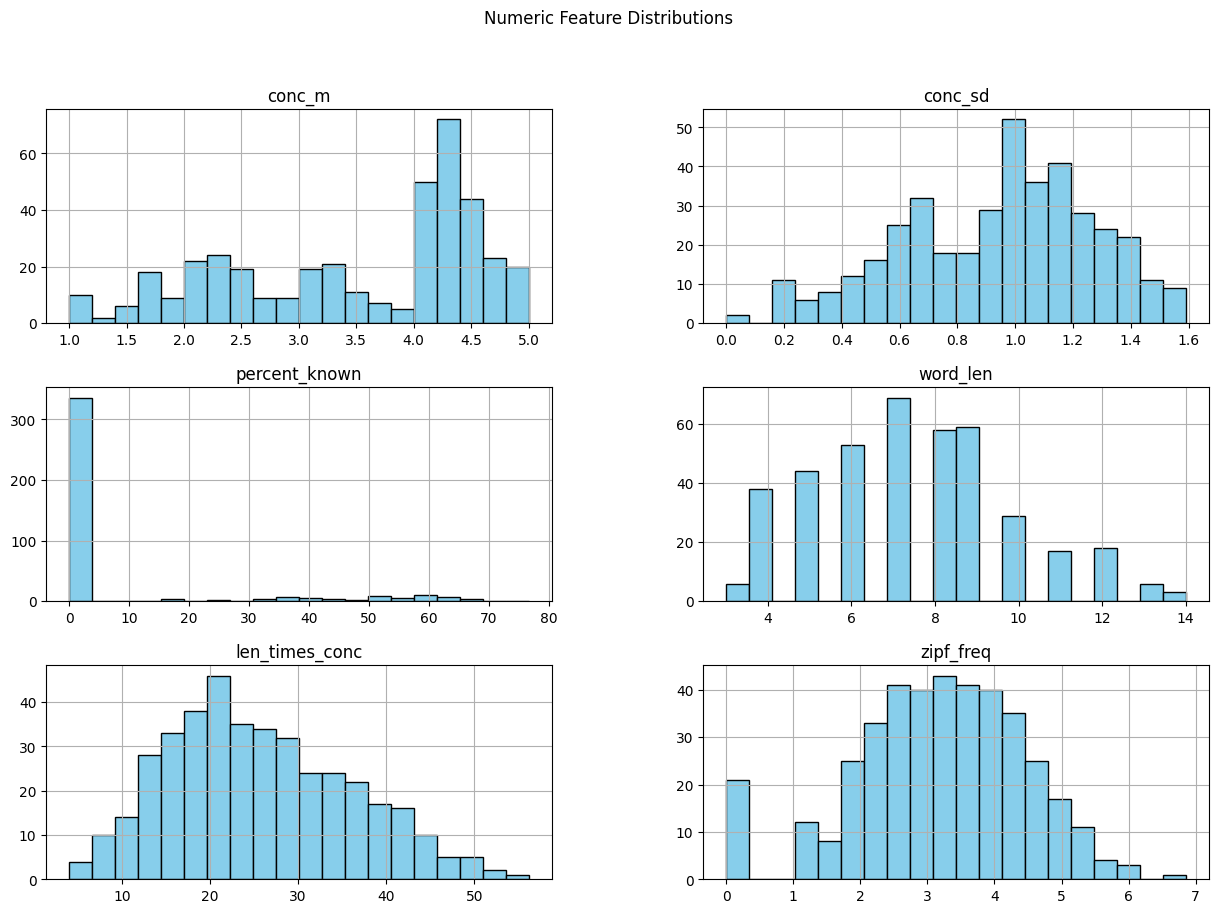

In [ ]:
df[numeric_cols].hist(bins=20, figsize=(15,10), color='skyblue', edgecolor='black')
plt.suptitle("Numeric Feature Distributions")
plt.show()


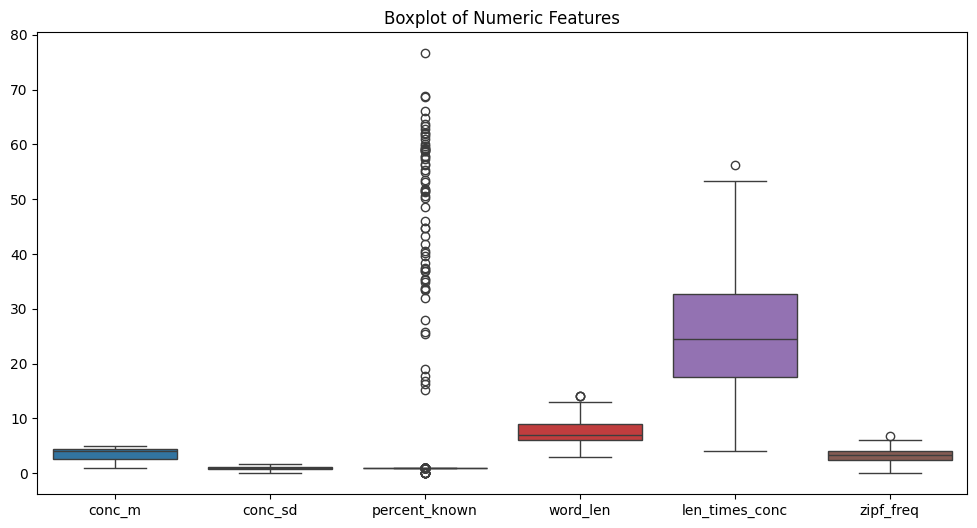

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Numeric Features")
plt.show()

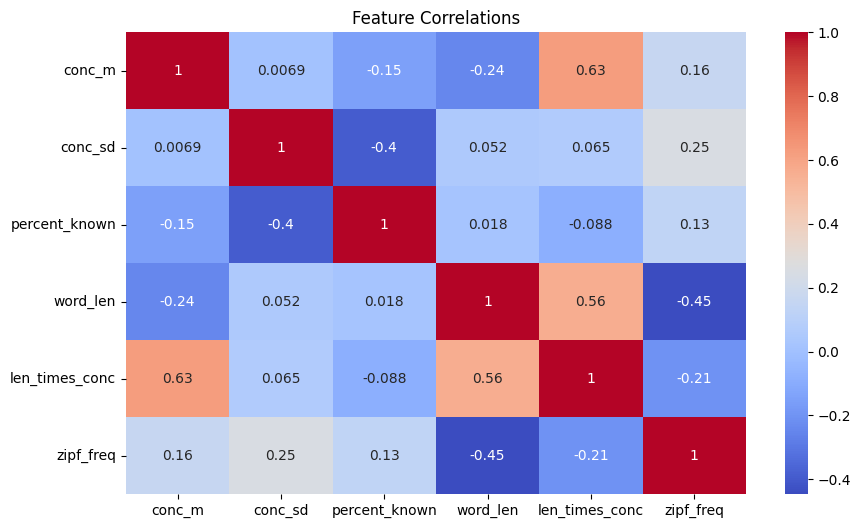

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()


Value counts for dom_pos:
 dom_pos
NOUN     128
VERB     110
ADJ       73
PROPN     58
ADV       25
ADP        2
INTJ       1
SCONJ      1
AUX        1
X          1
Name: count, dtype: int64


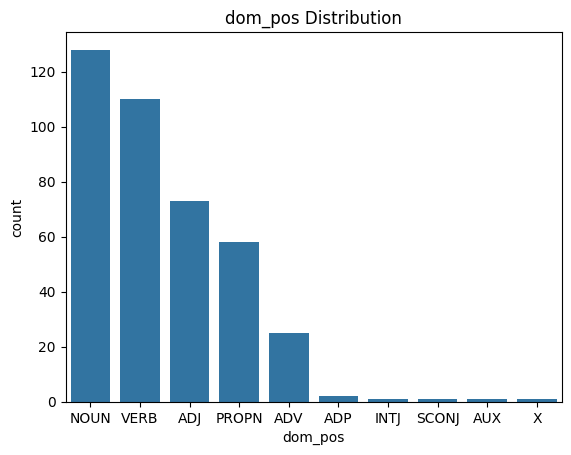


Value counts for author:
 author
Brysbaert    200
Eliot        120
Austen        41
Wilde         39
Name: count, dtype: int64


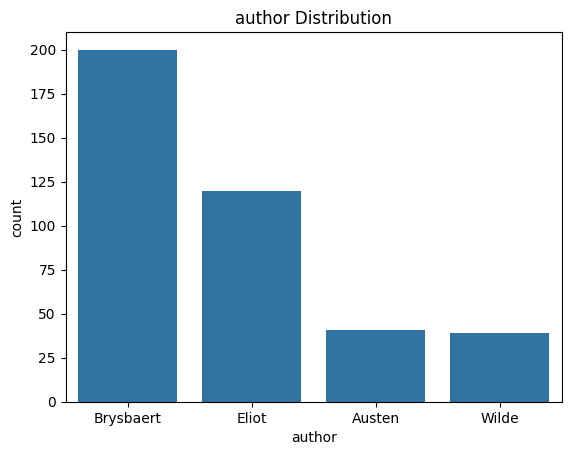


Value counts for source:
 source
literary    200
neutral     200
Name: count, dtype: int64


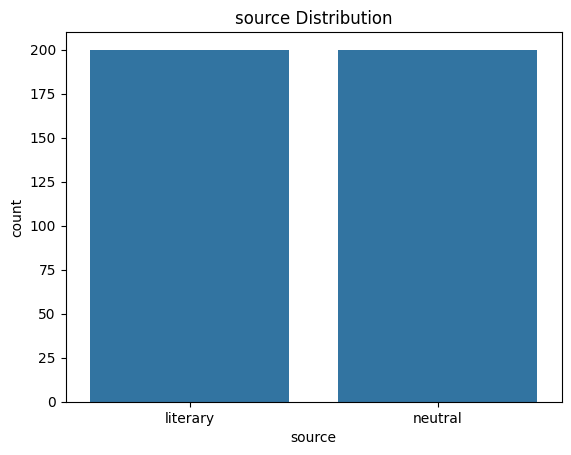

In [ ]:
categorical_cols = ["dom_pos", "author", "source"]
for col in categorical_cols:
    print(f"\nValue counts for {col}:\n", df[col].value_counts())
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.show()

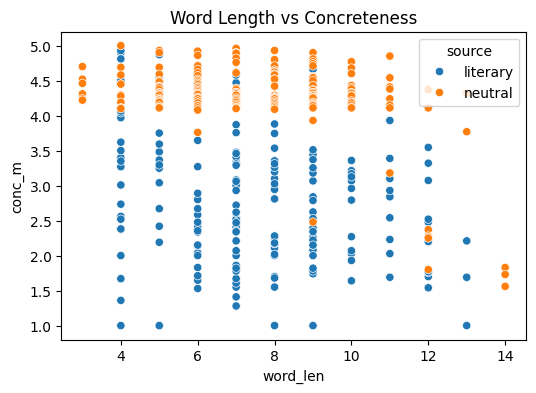

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="word_len", y="conc_m", hue="source")
plt.title("Word Length vs Concreteness")
plt.show()

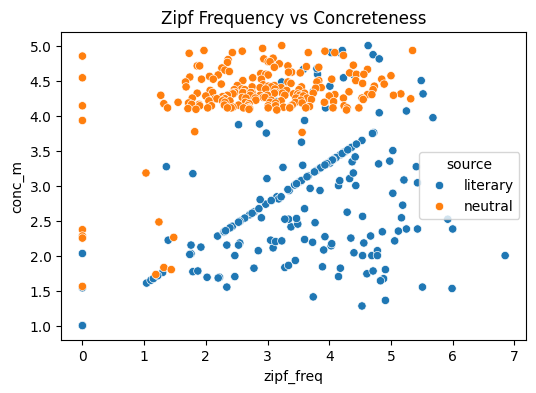

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="zipf_freq", y="conc_m", hue="source")
plt.title("Zipf Frequency vs Concreteness")
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
df['dom_pos'] = label_enc.fit_transform(df['dom_pos'])


In [9]:
print(df.isnull().sum())
numeric_cols = df.select_dtypes(include=np.number).columns
print(np.isinf(df[numeric_cols]).sum())

word              0
author            0
conc_m            0
conc_sd           0
percent_known     0
dom_pos           0
word_len          0
len_times_conc    0
zipf_freq         0
source            0
dtype: int64
conc_m            0
conc_sd           0
percent_known     0
dom_pos           0
word_len          0
len_times_conc    0
zipf_freq         0
dtype: int64


In [10]:
X = df.select_dtypes(include=[np.number])


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [12]:
features = [
    "word_len",
    "zipf_freq",
    "len_times_conc",
    "conc_sd",
    "percent_known"
]
target = "conc_m"  # Target variable (concreteness score)

X = df[features]
y = df[target]


In [13]:
X = X.fillna(X.mean())
y = y.fillna(y.mean())


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

In [17]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📊 Model Evaluation Metrics")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


📊 Model Evaluation Metrics
R² Score: 0.888
RMSE: 0.367


In [18]:
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": lr.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n📈 Feature Importance (Linear Regression Coefficients)")
print(coef_df)


📈 Feature Importance (Linear Regression Coefficients)
          Feature  Coefficient
2  len_times_conc     1.186608
1       zipf_freq     0.028623
3         conc_sd    -0.070494
4   percent_known    -0.082033
0        word_len    -0.930721


/tmp/ipython-input-673045810.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


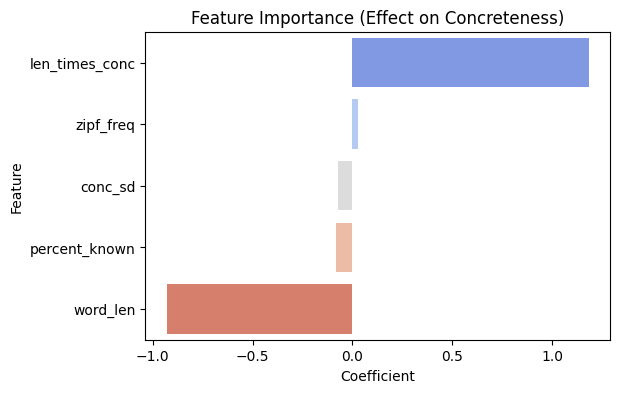

In [19]:
plt.figure(figsize=(6,4))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
plt.title("Feature Importance (Effect on Concreteness)")
plt.show()

**Predicting concreteness for a new word **

In [20]:
df = pd.read_csv("/content/literary_brysbaert_combined.csv")

In [21]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


In [22]:
        pip install wordfreq

In [23]:
from wordfreq import zipf_frequency
import spacy
import numpy as np

#(for POS tagging)
nlp = spacy.load("en_core_web_sm")

# Example test word
word = "imagination"

In [24]:
zipf_freq = zipf_frequency(word, "en")
word_len = len(word)
doc = nlp(word)
dom_pos = doc[0].pos_ if len(doc) > 0 else "X"

In [25]:
pos_map = {"NOUN": 1, "VERB": 2, "ADJ": 3, "ADV": 4}
pos_num = pos_map.get(dom_pos, 0)

In [26]:
#mean values from the training data for conc_sd, percent_known, and len_times_conc
mean_conc_sd = df['conc_sd'].mean()
mean_percent_known = df['percent_known'].mean()
mean_len_times_conc = df['len_times_conc'].mean()

test_features = np.array([[word_len, zipf_freq, mean_len_times_conc, mean_conc_sd, mean_percent_known]])

In [27]:
test_scaled = scaler.transform(test_features)

#Predict
predicted_concreteness = model.predict(test_scaled)

print(f"Word: {word}")
print(f"Predicted Concreteness: {predicted_concreteness[0]:.3f}")


Word: imagination
Predicted Concreteness: 2.149


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Interactive Word Concreteness Predictor

In [41]:
import numpy as np
import pandas as pd
import spacy
from wordfreq import zipf_frequency


nlp = spacy.load("en_core_web_sm")


pos_map = {"NOUN": 1, "VERB": 2, "ADJ": 3, "ADV": 4, "X": 0}


In [40]:
def predict_concreteness(word, model, scaler, feature_columns):
    zipf_freq = zipf_frequency(word, "en")
    word_len = len(word)
    doc = nlp(word)
    dom_pos = doc[0].pos_ if len(doc) > 0 else "X"

    pos_map = {"NOUN": 1, "VERB": 2, "ADJ": 3, "ADV": 4, "X": 0}
    pos_num = pos_map.get(dom_pos, 0)


In [57]:
try:
    #use X_train (exists)
    feature_columns = list(X_train.columns)
    print("Using feature_columns from X_train.")
except Exception:
    try:

        feature_columns = list(X.columns)
        print("Using feature_columns from X.")
    except Exception:

        feature_columns = [
            "zipf_freq",
            "word_len",
            "len_times_conc",
            "conc_sd",
            "percent_known"
        ]
        print("Using fallback default feature_columns.")


Using feature_columns from X_train.


In [54]:
for col in feature_columns:
        if col not in test_df.columns:
            test_df[col] = 0
test_df = test_df[feature_columns]


In [61]:
test_data = {
            "zipf_freq": zipf_freq,
            "word_len": word_len,
            "len_times_conc": word_len * zipf_freq,
            "conc_sd": 0.0,
            "percent_known": 0.0,
            "dom_pos": pos_num
        }

test_df = pd.DataFrame([test_data])

for col in feature_columns:
            if col not in test_df.columns:
                test_df[col] = 0
test_df = test_df[feature_columns]

In [71]:
try:
    print("✅ Test data ready, now scaling...")


    feature_columns = [
        "word_len",
        "zipf_freq",
        "len_times_conc",
        "conc_sd",
        "percent_known"
    ]
    test_df = test_df[feature_columns]

    test_scaled = scaler.transform(test_df)
    print("✅ Scaling complete, predicting...")

    predicted = model.predict(test_scaled)[0]
    print(f"🎯 Predicted concreteness: {predicted:.3f}")

except Exception as e:
    print(f"❌ ERROR: {e}")

print("Type a word (or 'exit' to stop):\n")

✅ Test data ready, now scaling...
✅ Scaling complete, predicting...
🎯 Predicted concreteness: 4.769
Type a word (or 'exit' to stop):



In [ ]:
while True:
    word = input("Enter word ➤ ").strip()
    if word.lower() in ["exit", "quit", "stop"]:
        print("👋 Exiting predictor.")
        break
    if word == "":
        continue
    predict_concreteness(word, model, scaler, feature_columns)

Enter word ➤ jumanji

--- Predicting for: jumanji ---
POS: PROPN | Zipf: 2.340 | Len: 7
✅ Test data ready, now scaling...
✅ Scaling complete, predicting...
🎯 Predicted concreteness: 2.868
Enter word ➤ human

--- Predicting for: human ---
POS: NOUN | Zipf: 5.350 | Len: 5
✅ Test data ready, now scaling...
✅ Scaling complete, predicting...
🎯 Predicted concreteness: 4.908
Enter word ➤ unorthodox

--- Predicting for: unorthodox ---
POS: ADJ | Zipf: 3.160 | Len: 10
✅ Test data ready, now scaling...
✅ Scaling complete, predicting...
🎯 Predicted concreteness: 3.445
Enter word ➤ existentialism

--- Predicting for: existentialism ---
POS: NOUN | Zipf: 2.590 | Len: 14
✅ Test data ready, now scaling...
✅ Scaling complete, predicting...
🎯 Predicted concreteness: 2.390
Enter word ➤ tree

--- Predicting for: tree ---
POS: NOUN | Zipf: 4.850 | Len: 4
✅ Test data ready, now scaling...
✅ Scaling complete, predicting...
🎯 Predicted concreteness: 4.450
